In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from src.wimbd_ import BasePaths as PATHS, Colors
from src.wimbd_ import DataConfigs as CONFIG
from src.wimbd_ import post_filter, filter_percentile, load_results
from src.wimbd_ import ProcessTriviaQA as ptqa
from src.utils import remove_nested_lists, softmax
from src.analysis import AnalyzeNgrams as an

from datetime import datetime
pd.set_option('display.max_columns', None)

# Generate a timestamp
timestamp = datetime.now().strftime("%Y-%m-%d-%H:%M")

[nltk_data] Downloading package punkt to
[nltk_data]     /local/home/antonis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /local/home/antonis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[dynet] random seed: 1234
[dynet] allocating memory: 32MB
[dynet] memory allocation done.


In [2]:
task_coverage_pth = "./results/n-grams/triviaqa/pile/exp_3/validation-set/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaFalse/3/common/task-p-coverage.pkl"
task_coverage = pd.read_pickle(task_coverage_pth)

In [3]:
all_models = ['pythia-12b', 'pythia-6.9b', 'pythia-2.8b', 'pythia-1.4b', 'pythia-410m', 'pythia-160m', 'pythia-70m', 'pythia-31m', 'pythia-14m']
large_models = ['pythia-12b', 'pythia-6.9b', 'pythia-2.8b', 'pythia-1.4b']
small_models = ['pythia-410m', 'pythia-160m', 'pythia-70m', 'pythia-31m', 'pythia-14m']

N_GRAMS = 5
ALIGN_THRESH = 0.8
# BASE_DIR = f"./results/n-grams/trivia_qa/pile/exp_3/test-set/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaFalse/"
# BASE_DIR = f"./results/n-grams/triviaqa/pile/exp_3/validation-set/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaFalse"
# BASE_DIR = f"./results/n-grams/triviaqa/pile/exp_3/validation-set/n_samples_None_fkeyFalse_rkeyFalse_fstopFalse_onlyalphaFalse"
DATASET = "examples_dfs_0-shot_common_pythia_models.pkl" # "examples_dfs_4-shot_common_models.pkl"
TASKS = "triviaqa"
BASE_DIR = PATHS.base_ngram_paths[TASKS]['base_path'][N_GRAMS]
OMMIT_TASKS = False
TASKS_OMMIT = ["formal_logic"]
POST_FILTER = True

# BASE_DIR = PATHS.base_ngram_paths[TASKS]['base_path']
BASE_PATH = os.path.join(BASE_DIR, f"{N_GRAMS}")
METHOD = "0-shot_common"
BASE_PATH_COMMON = os.path.join(BASE_PATH, "common")
BASE_PATH_ALL = os.path.join(BASE_PATH, "all")
# FIG_DIR = os.path.join("/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/figures", DATASET, timestamp)
# if not os.path.exists(FIG_DIR):
#     os.makedirs(FIG_DIR)

# RESULTS_PATH = os.path.join(BASE_DIR, str(N_GRAMS), 'common', DATASET)
RESULTS_PATH = os.path.join(BASE_DIR, str(N_GRAMS), DATASET)
FIGS_PTH = "./figures/trivia_qa"

print(f"BASE PATH: {BASE_PATH}")

VIEW_COLS = ['Q', 'A', 'question', 'value', 'align_score', 'em', 'answer']

BASE PATH: ./results/n-grams/triviaqa/pile/exp_3/validation-set/n_samples_None_fkeyFalse_rkeyFalse_fstopFalse_onlyalphaFalse/5


In [4]:
# filter outliers
pickle_file = pd.read_pickle(RESULTS_PATH)
# df = pd.DataFrame(pickle_file).T.sort_values("value", ascending=False)

# filter
# open
examples_models_pth = os.path.join(BASE_PATH, f"examples_dfs_{METHOD}_post-processed.pkl")
if os.path.exists(examples_models_pth):
    with open(examples_models_pth, 'rb') as f:
        examples_models = pickle.load(f)
else:
    examples_models = ptqa.process_model_examples(pickle_file, p=0.99999)
examples_model = examples_models['pythia-12b']
colors = sns.color_palette('hls', len(examples_models))

In [5]:
# # save
# with open(os.path.join(BASE_PATH, f"examples_dfs_{METHOD}_post-processed.pkl"), 'wb') as f:
#     pickle.dump(examples_models, f)

In [6]:
examples_models_ = {model: data[data['align_score'] > ALIGN_THRESH] for model, data in examples_models.items()}

In [10]:
examples_models_['pythia-12b']['value']

25       1837603
22       1815794
38       1022052
37       1022052
75        615844
          ...   
42026          0
42027          0
42031          0
42032          0
92105          0
Name: value, Length: 92106, dtype: object

In [7]:
examples_models_['pythia-12b'].head(20)

,Q,A,value,example,task,pair,example_clean,coverage,query,sum,count,id,gold,question,question_id,question_source,entity_pages,search_results,answer,lls,result,em,align_score
25,in the middle of the,Pear,1837603,{'question': 'Which fruit can go in the middle...,triviaqa,"(in the middle of the, Pear)",Which fruit can go in the middle of the word a...,0.327478,Which fruit can go in the middle of the word a...,1841604,12,11677_0,0,Which fruit can go in the middle of the word a...,qz_871,https://www.quiz-zone.co.uk/,"{'doc_source': [], 'filename': [], 'title': []...","{'description': [], 'filename': [], 'rank': []...","{'aliases': ['Pear (fruit)', 'Pear tree', 'Pea...",Apple,Apple,0,78.528419
22,at the beginning of the,45,1815794,{'question': 'How many American states were th...,triviaqa,"(at the beginning of the, 45)",How many American states were there at the beg...,0.327478,How many American states were there at the beg...,1934174,9,6957_0,0,How many American states were there at the beg...,odql_9796,http://www.odquiz.org.uk/,"{'doc_source': [], 'filename': [], 'title': []...","{'description': [], 'filename': [], 'rank': []...","{'aliases': ['45', 'forty-five'], 'normalized_...",Ten,Ten,0,76.193657
38,is the square root of,99,1022052,{'question': 'What whole two-digit number is t...,triviaqa,"(is the square root of, 99)",What whole two-digit number is the square root...,0.327478,What whole two-digit number is the square root...,1022324,6,11921_0,0,What whole two-digit number is the square root...,bb_5981,http://www.businessballs.com/,"{'doc_source': [], 'filename': [], 'title': []...","{'description': [], 'filename': [], 'rank': []...","{'aliases': ['99', 'ninety-nine'], 'normalized...",9,9,0,83.908638
37,is the square root of,12,1022052,{'question': 'What is the square root of 144?'...,triviaqa,"(is the square root of, 12)",What is the square root of 144?,0.327478,What is the square root of 144?,1025754,3,4141_0,0,What is the square root of 144?,qb_7961,http://www.quizballs.com/,"{'doc_source': [], 'filename': [], 'title': []...","{'description': [], 'filename': [], 'rank': []...","{'aliases': ['twelve', '12'], 'normalized_alia...",12,12,1,84.854713
75,President of the United States,Ronald Reagan,615844,"{'question': 'June 5, 2004 saw the death of wh...",triviaqa,"(President of the United States, Ronald Reagan)","June 5, 2004 saw the death of what man, the 40...",0.327478,"June 5, 2004 saw the death of what man, the 40...",618248,12,15100_0,0,"June 5, 2004 saw the death of what man, the 40...",qg_1692,https://quizguy.wordpress.com/,"{'doc_source': [], 'filename': [], 'title': []...","{'description': [], 'filename': [], 'rank': []...","{'aliases': ['President Regan', 'Ronald Reagan...",Ronald Reagan,Ronald Reagan,1,82.827179
76,What is the second biggest,Birmingham,603704,{'question': 'What is the second biggest city ...,triviaqa,"(What is the second biggest, Birmingham)",What is the second biggest city in the UK?,0.327478,What is the second biggest city in the UK?,607048,5,6697_0,0,What is the second biggest city in the UK?,qz_6268,https://www.quiz-zone.co.uk/,"{'doc_source': [], 'filename': [], 'title': []...","{'description': [], 'filename': [], 'rank': []...","{'aliases': ['County Borough of Birmingham', '...",Birmingham,Birmingham,1,83.078804
45,is one of the few,Southwest,573790,"{'question': 'What successful, no-frills airli...",triviaqa,"(is one of the few, Southwest)","What successful, no-frills airline is headquar...",0.327478,"What successful, no-frills airline is headquar...",965976,20,12688_0,0,"What successful, no-frills airline is headquar...",qg_3574,https://quizguy.wordpress.com/,"{'doc_source': [], 'filename': [], 'title': []...","{'description': [], 'filename': [], 'rank': []...","{'aliases': ['RedBellyRadio', 'Southwest Airli...",Southwest Airlines,Southwest Airlines,1,74.529900
99,is the square root of,0.5,511026,{'question': 'What is the square root of 0.25?...,triviaqa,"(is the square root of, 0.5)",What i

In [8]:
# examples_model_small = examples_model.iloc[0:3]
# examples_model_small_filtered, indices_kept = ptqa.calculate_alignment_scores(examples_model_small, 75, 1)

In [9]:
# display_cols = ['Q', 'A', 'value', 'example']
# pd.set_option('display.max_rows', 1000)
# pd.set_option('display.max_colwidth', 2)  # Set to None to display full content
# examples_model[display_cols].iloc[200:400]

In [10]:
from src.analysis import AnalyzeNgrams as an

# coverage_path = os.path.join(BASE_PATH_COMMON, "task-coverage.pkl")
# task_cov = an.calculate_average_task_coverage(BASE_PATH_ALL, [TASKS], [N_GRAMS])

In [11]:
# # Assuming 'value' is the column with values to bin and we want 5 bins between 1 and 10000
# examples_model = an.create_bins(examples_model, 'value', 1, 10000, 4)

# example_samples_model = ptqa.get_random_samples_by_interval(examples_model, 100)

# ptqa.plot_avg_em_by_log_interval(example_samples_model, log_axis=True)
# ptqa.plot_avg_em_by_log_interval(examples_model, log_axis=True)
# # plot_avg_em_by_log_interval(example_samples_model, log_axis=False)

In [12]:
len(examples_models_['pythia-12b'])

92106

[nltk_data] Downloading package punkt to
[nltk_data]     /local/home/antonis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /local/home/antonis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


interval
[0.0000, 2000.0000)        89865
[2000.0000, 4000.0000)     813  
[10000, ∞)                 739  
[4000.0000, 6000.0000)     349  
[6000.0000, 8000.0000)     196  
[8000.0000, 10000.0000)    144  
Name: count, dtype: int64
avg_df =                          interval_start     avg_y
interval                                         
[0.0000, 2000.0000)      0.0             0.354621
[2000.0000, 4000.0000)   2000.0          0.405904
[4000.0000, 6000.0000)   4000.0          0.481375
[6000.0000, 8000.0000)   6000.0          0.479592
[8000.0000, 10000.0000)  8000.0          0.506944
[10000, ∞)               10000.0         0.500677
avg_y: interval
[0.0000, 2000.0000)        0.354621
[2000.0000, 4000.0000)     0.405904
[4000.0000, 6000.0000)     0.481375
[6000.0000, 8000.0000)     0.479592
[8000.0000, 10000.0000)    0.506944
[10000, ∞)                 0.500677
Name: avg_y, dtype: float64
Saved figure in ./figures/trivia_qa/avg_em_by_log_interval_all_logFalse_value_aligned0.8.pdf
inter

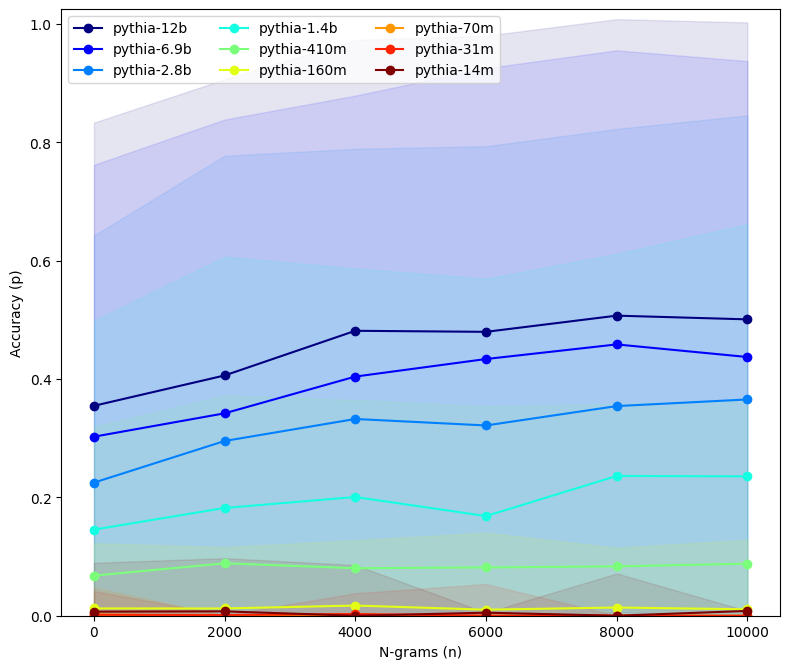

In [18]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# color_palette = sns.color_palette('husl', len(examples_models))
# color_palette = sns.color_palette('Set2', len(examples_models_))
color_palette = plt.get_cmap('jet', len(examples_models_))
color_palette = [color_palette(i) for i in range(len(examples_models_))]

is_log = False
plot_var = 'value'
savefile = os.path.join(FIGS_PTH, f"avg_em_by_log_interval_all_log{is_log}_{plot_var}_aligned{ALIGN_THRESH}.pdf")
for i, (model_name, data) in enumerate(examples_models_.items()):
    data = an.create_bins(data, plot_var, 0, 10000, 5, is_log)
    # data = ptqa.get_random_samples_by_interval(data, 85)
    ax = ptqa.plot_variable_by_interval(data, log_axis=is_log,
                                 x_column='interval', y_column='em',
                                 save_pth=savefile, ax=ax, 
                                 color=color_palette[i], label=model_name,
                                #  title=f'Performance vs. Ngrams for Different Models, {TASKS}, N={N_GRAMS}',
                                 plot_std=True, ylimits=[0,1.025])

In [14]:
examples_model = examples_models['pythia-12b']
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 500)
# Corrected code
pd.set_option('display.max_colwidth', 1)
examples_model[VIEW_COLS].head(5)

,Q,A,question,value,align_score,em,answer
25,in the middle of the,Pear,Which fruit can go in the middle of the word aped to make a new word?,1837603,78.528419,0,"{'aliases': ['Pear (fruit)', 'Pear tree', 'Pear', 'Culture of pear', '🍐', 'Pear juice', 'Pearwood', 'Pyrus'], 'normalized_aliases': ['🍐', 'culture of pear', 'pyrus', 'pearwood', 'pear tree', 'pear juice', 'pear', 'pear fruit'], 'matched_wiki_entity_name': '', 'normalized_matched_wiki_entity_name': '', 'normalized_value': 'pear', 'type': 'WikipediaEntity', 'value': 'Pear'}"
22,at the beginning of the,45,How many American states were there at the beginning of the twentieth century?,1815794,76.193657,0,"{'aliases': ['45', 'forty-five'], 'normalized_aliases': ['45', 'forty five'], 'matched_wiki_entity_name': '', 'normalized_matched_wiki_entity_name': '', 'normalized_value': '45', 'type': 'Numerical', 'value': '45'}"
38,is the square root of,99,What whole two-digit number is the square root of 9801?,1022052,83.908638,0,"{'aliases': ['99', 'ninety-nine'], 'normalized_aliases': ['ninety nine', '99'], 'matched_wiki_entity_name': '', 'normalized_matched_wiki_entity_name': '', 'normalized_value': '99', 'type': 'Numerical', 'value': '99'}"
37,is the square root of,12,What is the square root of 144?,1022052,84.854713,1,"{'aliases': ['twelve', '12'], 'normalized_aliases': ['twelve', '12'], 'matched_wiki_entity_name': '', 'normalized_matched_wiki_entity_name': '', 'normalized_value': '12', 'type': 'Numerical', 'value': '12'}"
75,President of the United States,Ronald Reagan,"June 5, 2004 saw the death of what man, the 40th President of the United States?",615844,82.827179,1,"{'aliases': ['President Regan', 'Ronald Reagan's Alzheimer's letter', 'Ronald W Reagan', '40th President of the United States', 'Reagan', 'Reaganian', 'Ronald Reagon', 'Reagen', 'Ronnie Reagan', 'Public image of Ronald Reagan', 'Ronald Reagan presidential campaign, 1976', 'Ronald Reagan', 'Reagan, Ronald', 'Reagan, Ronald Wilson', 'President Reagan', 'Reagan (president)', 'Health of Ronald Reagan', 'President Ronald Reagan', 'Ronald Reagan Centennial Commission Act', 'Ronald reagan', 'Reaganesque', 'Reaganite', 'Ronald Raegen', 'Ronald regean', 'Ronald Wilson Reagan', 'Ronald Regan', 'Ronald Reagan Centennial Commission', 'Dutch Reagan', 'Ronaldus Magnus', 'Ronald Reagen', 'Cultural and political image of Ronald Reagan', 'Ronal Reagan', 'Reagan Ronald', 'Ronald Raegan', 'Ronald W. Reagan'], 'normalized_aliases': ['reagan ronald wilson', 'reaganesque', 'ronald raegan', 'ronald reagon', 'ronald reagan s alzheimer s letter', 'ronald reagan', 'ronald w reagan', 'president reagan', 'reagan', 'reaganite', 'ronnie reagan', 'public image of ronald reagan', 'ronald reagen', 'reagan president', 'ronald regean', 'ronald regan', 'ronald wilson reagan', 'dutch reagan', '40th president of united states', 'reagen', 'ronald reagan presidential campaign 1976', 'ronaldus magnus', 'president regan', 'president ronald reagan', 'ronal reagan', 'ronald reagan centennial commission', 'health of ronald reagan', 'ronald raegen', 'cultural and political image of ronald reagan', 'reaganian', 'ronald reagan centennial commission act', 'reagan ronald'], 'matched_wiki_entity_name': '', 'normalized_matched_wiki_entity_name': '', 'normalized_value': 'ronald reagan', 'type': 'WikipediaEntity', 'value': 'Ronald Reagan'}"


In [15]:
question = "What is the medical term for high blood pressure?"
df_q = examples_model[examples_model['question'] == question]
df_q['Q']

18125    is the medical term for     
18123    term for high blood pressure
18124    medical term for high blood 
18122    the medical term for high   
18121    What is the medical term    
Name: Q, dtype: object

In [16]:
# from src.utils import normalize_string

# # Apply the function to each row of the DataFrame
# # examples_model[['q_coverage', 'a_coverage']] = examples_model.apply(calculate_qa_coverage, axis=1)

# coverage_df = an.calculate_qa_coverage(examples_model)

# coverage_df['q_coverage'].unique()

# coverage_df[coverage_df['q_coverage'] < 0]

In [17]:
is_log = False
plot_var = 'q_coverage'
x_label = 'Question Coverage (p)'

examples_model_cov_int = an.create_bins(coverage_df, plot_var, 
                                        -0.1, 1.0, 5, 
                                        is_log=is_log)

ptqa.plot_variable_by_interval(examples_model_cov_int, log_axis=is_log,
                                x_column='interval', y_column='em',
                                save_pth=savefile, 
                                label='pythia-12b',
                                title=f'Performance vs. {plot_var} for Different Models N={N_GRAMS}',
                                x_label=x_label, 
                                plot_std=True)

NameError: name 'coverage_df' is not defined